In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim=1000, output_dim=64))
# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128))
# Add a Dense layer with 10 units.
model.add(layers.Dense(10))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
Total params: 164,106
Trainable params: 164,106
Non-trainable params: 0
_________________________________________________________________


In [4]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))
# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences=True))
# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(layers.SimpleRNN(128))
model.add(layers.Dense(10))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          64000     
                                                                 
 gru (GRU)                   (None, None, 256)         247296    
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               49280     
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 361,866
Trainable params: 361,866
Non-trainable params: 0
_________________________________________________________________


In [5]:
encoder_vocab = 1000
decoder_vocab = 2000
encoder_input = layers.Input(shape=(None,))
encoder_embedded = layers.Embedding(input_dim=encoder_vocab, output_dim=64)(encoder_input)
# Return states in addition to output
output, state_h, state_c = layers.LSTM(64, return_state=True, name="encoder")(encoder_embedded)
encoder_state = [state_h, state_c]
decoder_input = layers.Input(shape=(None,))
decoder_embedded = layers.Embedding(input_dim=decoder_vocab, output_dim=64)(decoder_input)
# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = layers.LSTM(64, name="decoder")(decoder_embedded, initial_state=encoder_state)
output = layers.Dense(10)(decoder_output)
model = keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 64)     64000       ['input_1[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, None, 64)     128000      ['input_2[0][0]']                
                                                                                              

In [6]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

In [7]:
lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)
output = lstm_layer(paragraph3)

In [8]:
model = keras.Sequential()
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(5, 10)))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(10))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 5, 128)           38400     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 80,266
Trainable params: 80,266
Non-trainable params: 0
_________________________________________________________________


In [9]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 28
units = 64
output_size = 10  # labels are from 0 to 9
# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(None, input_dim))
    model = keras.models.Sequential([lstm_layer, keras.layers.BatchNormalization(), keras.layers.Dense(output_size),])
    return model

In [10]:
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]

In [11]:
model = build_model(allow_cudnn_kernel=True)
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="sgd", metrics=["accuracy"],)
model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1)

2023-10-27 11:36:11.000614: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


938/938 [==============================] - 23s 24ms/step - loss: 0.9020 - accuracy: 0.7107 - val_loss: 0.4957 - val_accuracy: 0.8434


Predicted result is: [3], target result is: 5


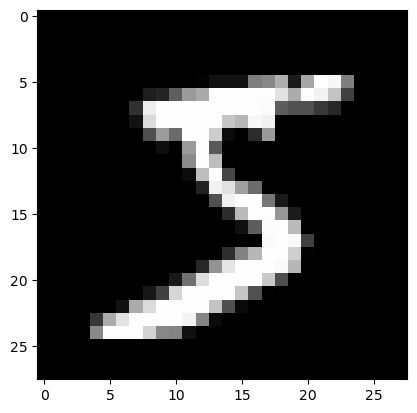

In [12]:
import matplotlib.pyplot as plt
with tf.device("CPU:0"):
    cpu_model = build_model(allow_cudnn_kernel=True)
    cpu_model.set_weights(model.get_weights())
    result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
    print("Predicted result is: %s, target result is: %s" % (result.numpy(), sample_label))
    plt.imshow(sample, cmap=plt.get_cmap("gray"))